# Densenet169

In [43]:
# Libraries

import torch
import torch.nn as nn
from PIL import Image
import os
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from torchvision.models import densenet169
from torch.utils.data import Dataset
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import DataLoader

## Model preparation

In [44]:
num_classes = 10    # number of genres

model = densenet169()   # model generation
model.classifier = nn.Linear(model.classifier.in_features, num_classes)

## Dataset preparation

In [45]:
class SpectrogramDataset(Dataset):
    def __init__(self, dataframe=None, csv_file=None, root_dir=None, transform=None, label_map=None):
        if dataframe is not None:
            self.annotations = dataframe.reset_index(drop=True)
        elif csv_file is not None:
            self.annotations = pd.read_csv(csv_file)
        else:
            raise ValueError("This should be either dataframe or csv!")

        self.root_dir = root_dir
        self.transform = transform
        self.label_map = label_map or self._build_label_map()

    def _build_label_map(self):
        labels = self.annotations['genre'].unique()
        return {label: idx for idx, label in enumerate(sorted(labels))}

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        filename = self.annotations.iloc[idx, 0]
        subfolder = filename.split('.')[0]
        filename = filename[:-4] + '.png'
        img_name = os.path.join(self.root_dir, subfolder, filename)
        image = Image.open(img_name).convert('RGB')
        label_str = self.annotations.iloc[idx, 1]
        label = self.label_map[label_str]

        if self.transform:
            image = self.transform(image)

        return image, label

In [46]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Split the dataset

train_dataset = SpectrogramDataset(
    csv_file='densenet_dataset_split/train.csv',
    root_dir='../project_data/spectrograms',
    transform=transform
)

val_dataset = SpectrogramDataset(
    csv_file='densenet_dataset_split/valid.csv',
    root_dir='../project_data/spectrograms',
    transform=transform
)

test_dataset = SpectrogramDataset(
    csv_file='densenet_dataset_split/test.csv',
    root_dir='../project_data/spectrograms',
    transform=transform
)

In [47]:
# GPU device verification

print(torch.__version__)
print(torch.version.cuda)
print(torch.backends.cudnn.version())

if torch.cuda.is_available():
    print(f"CUDA is available. Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. Using CPU.")

2.5.1
11.8
90100
CUDA is available. Using GPU: NVIDIA GeForce GTX 1650 Ti


## Training + Validation

In [48]:
def get_filename_with_date(prefix="model", extension="pth"):        # for saving models
    now = datetime.datetime.now()
    date_str = now.strftime("%d_%b_%H_%M")
    return f"{prefix}_{date_str}.{extension}"


class EarlyStopping:        #
    def __init__(self, patience=5, delta=0.0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model_state = model.state_dict()

In [49]:
def optimizer_to(optimizer, device):            # Send optimizer parameters to device
    for param_group in optimizer.param_groups:
        for param in param_group['params']:
            param.data = param.data.to(device)
    return optimizer


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

start_epoch = 0
num_epochs = 25

In [50]:
# Model training

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, patience=5):

    model = model.to(device, non_blocking=True)
    early_stopping = EarlyStopping(patience=patience, delta=0.001)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    train_precisions, val_precisions = [], []

    best_model_state = None
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        # --- TRAIN ---
        model.train()
        total_train_loss, correct_train, total_train = 0, 0, 0
        y_train_true, y_train_pred = [], []

        for images, labels in train_loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

            y_train_true.extend(labels.cpu().numpy())
            y_train_pred.extend(predicted.cpu().numpy())

        avg_train_loss = total_train_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_precision = precision_score(y_train_true, y_train_pred, average='macro', zero_division=0)

        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
        train_precisions.append(train_precision)

        # --- VALIDATION ---
        model.eval()
        total_val_loss, correct_val, total_val = 0, 0, 0
        y_val_true, y_val_pred = [], []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                outputs = model(images)
                total_val_loss += criterion(outputs, labels).item()

                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

                y_val_true.extend(labels.cpu().numpy())
                y_val_pred.extend(predicted.cpu().numpy())

        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_precision = precision_score(y_val_true, y_val_pred, average='macro', zero_division=0)

        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)
        val_precisions.append(val_precision)

        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.4f} | Train Prec: {train_precision:.4f}")
        print(f"Epoch {epoch+1} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f} | Val Prec: {val_precision:.4f}")

        # Early stopping
        '''
        early_stopping(avg_val_loss, model)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()

        if early_stopping.early_stop:
            print(f"⏹️ Early stopping at epoch {epoch+1}")
            break

        # Przywróć najlepszy model
        if best_model_state is not None:
            model.load_state_dict(best_model_state)
        '''


    metrics = {
        'train_loss': train_losses,
        'train_accuracy': train_accuracies,
        'train_precision': train_precisions,
        'val_loss': val_losses,
        'val_accuracy': val_accuracies,
        'val_precision': val_precisions
    }

    final_metrics = {
        'train_loss': train_losses[-1],
        'train_accuracy': train_accuracies[-1],
        'train_precision': train_precisions[-1],
        'val_loss': val_losses[-1],
        'val_accuracy': val_accuracies[-1],
        'val_precision': val_precisions[-1]
    }

    return model, metrics, final_metrics

In [52]:
torch.cuda.empty_cache()
model_trained, metrics, final_metrics = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, device=device)

Epoch 1 | Train Loss: 1.9064 | Train Acc: 0.3486 | Train Prec: 0.4118
Epoch 1 | Val Loss: 2.1066 | Val Acc: 0.2067 | Val Prec: 0.0904
Epoch 2 | Train Loss: 1.4161 | Train Acc: 0.5486 | Train Prec: 0.5649
Epoch 2 | Val Loss: 1.4458 | Val Acc: 0.5000 | Val Prec: 0.5742
Epoch 3 | Train Loss: 1.1338 | Train Acc: 0.6129 | Train Prec: 0.6091
Epoch 3 | Val Loss: 1.2707 | Val Acc: 0.5600 | Val Prec: 0.5582
Epoch 4 | Train Loss: 0.9750 | Train Acc: 0.6757 | Train Prec: 0.6682
Epoch 4 | Val Loss: 1.2231 | Val Acc: 0.6267 | Val Prec: 0.6818
Epoch 5 | Train Loss: 0.8029 | Train Acc: 0.7514 | Train Prec: 0.7500
Epoch 5 | Val Loss: 1.0973 | Val Acc: 0.6267 | Val Prec: 0.6315
Epoch 6 | Train Loss: 0.6588 | Train Acc: 0.7929 | Train Prec: 0.7907
Epoch 6 | Val Loss: 1.2461 | Val Acc: 0.6000 | Val Prec: 0.6649
Epoch 7 | Train Loss: 0.5409 | Train Acc: 0.8371 | Train Prec: 0.8380
Epoch 7 | Val Loss: 1.1379 | Val Acc: 0.6067 | Val Prec: 0.6415
Epoch 8 | Train Loss: 0.4461 | Train Acc: 0.8771 | Train Prec:

## Testing

In [53]:
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

Accuracy: 0.7800
Precision (macro): 0.8018
F1 Score (macro): 0.7830
Confusion Matrix:


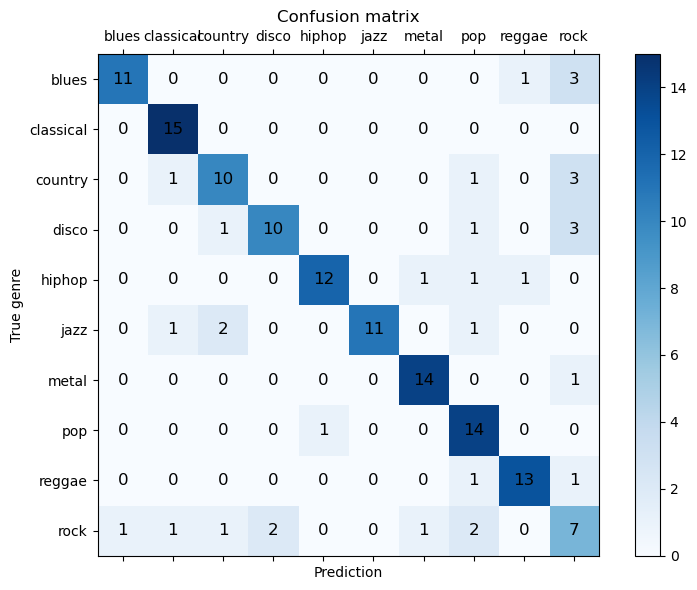

In [54]:
test_accuracy = accuracy_score(y_true, y_pred)
test_precision = precision_score(y_true, y_pred, average='macro')
test_f1 = f1_score(y_true, y_pred, average='macro')
conf_matrix = confusion_matrix(y_true, y_pred)

print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision (macro): {test_precision:.4f}")
print(f"F1 Score (macro): {test_f1:.4f}")
print("Confusion Matrix:")

class_names = test_dataset.label_map.keys()

fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(conf_matrix, cmap='Blues')
fig.colorbar(cax)

ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)

for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix[i])):
        ax.text(j, i, str(conf_matrix[i][j]),
                va='center', ha='center', color='black', fontsize=12)

# Oznaczenia osi
plt.xlabel('Prediction')
plt.ylabel('True genre')
plt.title('Confusion matrix')
plt.tight_layout()
plt.show()

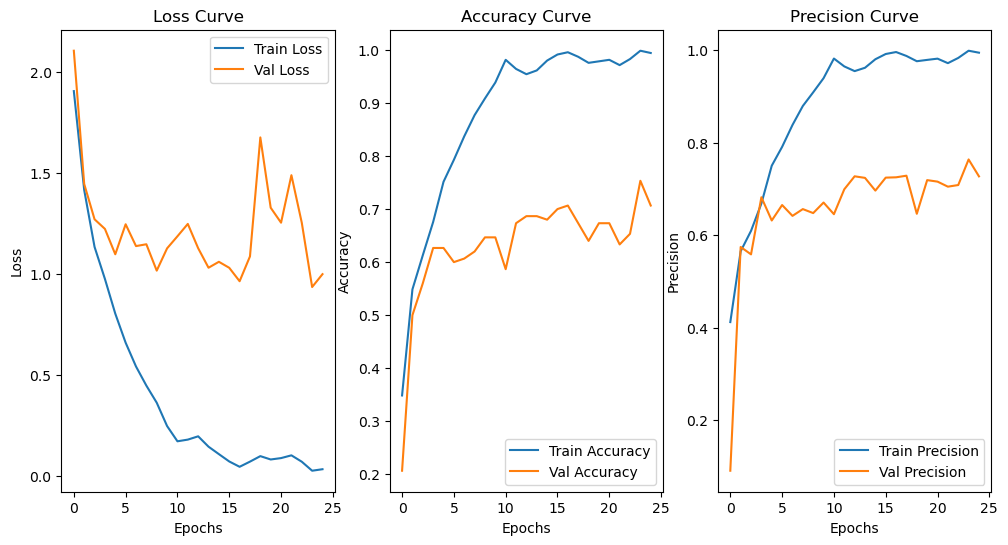

In [55]:
# Plotting the Loss and Accuracy curves
plt.figure(figsize=(12, 6))

# Losses
plt.subplot(1, 3, 1)
plt.plot(range(num_epochs), metrics['train_loss'], label='Train Loss')
plt.plot(range(num_epochs), metrics['val_loss'], label='Val Loss')
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1, 3, 2)
plt.plot(range(num_epochs), metrics['train_accuracy'], label='Train Accuracy')
plt.plot(range(num_epochs), metrics['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Precision
plt.subplot(1, 3, 3)
plt.plot(range(num_epochs), metrics['train_precision'], label='Train Precision')
plt.plot(range(num_epochs), metrics['val_precision'], label='Val Precision')
plt.title("Precision Curve")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.legend()

plt.show()

## Saving

In [57]:
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    # 'loss': loss, ???????????????????????????????
    'train_accuracies': metrics['train_accuracy'],
    'val_accuracies': metrics['val_accuracy'],
    'train_losses': metrics['train_loss'],
    'val_losses': metrics['val_loss'],
    'train_precisions: ': metrics['train_precision'],
    'val_precisions': metrics['val_precision'],
    'test_accuracy' : test_accuracy,
    'test_precision' : test_precision,
    'test_f1': test_f1,
    'conf_matrix': conf_matrix
}, get_filename_with_date())

# CLEAR CACHE

In [58]:
torch.cuda.empty_cache()